Data sourced from https://www.kaggle.com/datasets/utkarshxy/stock-markettweets-lexicon-data  
Some data processing abridged from https://www.kaggle.com/code/juniorbueno/stock-market-sentimen-bert-tokenizer  
Various code snippets from COMP9444 assignment 'paraphrased'

You will need to install (via pip3): torch, matplotlib, numpy, nltk.  
You will also need to run (with python3 in terminal)  
>>>import nltk  
>>>nltk.download('stopwords')

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import csv
import re
from nltk import stem
from nltk.corpus import stopwords
from collections import Counter
from random import shuffle

# Prepare word stemmer and stopwords list for later sanitisation
stemm = stem.porter.PorterStemmer()
stops = set(stopwords.words('english'))

with open('tweets_labelled.csv', encoding='utf8') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=';')
    data = list(readCSV)

# Encode positive, neutral and negative sentiment as one-hot vectors
def sentiment_text2vect(sentiment):
    if (sentiment == "positive"): return [1,0,0]
    elif (sentiment == "neutral"): return [0,1,0]
    else: return [0,0,1]
data = list(zip(*data))
text = data[2][1:]
sentiment = list(map(lambda n: sentiment_text2vect(n), data[3][1:]))

In [65]:
# Hyperparameters
dict_word_frequency_requirement = 20 # the number of times a word has to appear to be given
# it's own encoding. All words under this limit are encoded as the same 'unknown' word.
train_proportion = 0.8
hidden_layer_size = 70
learning_rate = 0.001
#batch_size = 32 # Batch size 1 only for now.
epochs = 10

In [66]:
# Regex removal of various undesirable parts of a tweet
def clean_tweet(tweet):
  tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet) # Twitter handle removal
  tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet) # URL removal
  tweet = re.sub(r"[']", "", tweet) # Apostrophe removal
  tweet = re.sub(r"[^a-zA-Z.!?]", ' ', tweet) # Non alphabetic or sentence ender removal
  tweet = re.sub(r"([^a-zA-Z])", r" \1 ", tweet) # Places spaces around sentence enders,
  # so they are encoded as their own words, rather than being lumped in with other words.
  tweet = re.sub(r" +", ' ', tweet) # Excess whitespace removal
  tweet = tweet.lower() # Send tweet to lowercase
  return tweet

In [67]:
def tokenize(tweet):
    tweet = clean_tweet(tweet)
    tweet = filter(lambda w: w not in stops, tweet.strip().split()) # Remove stopwords
    return list(map(stemm.stem, tweet)) # Reduce words to their stems.

In [68]:
test = text[1]
print(test)
print(tokenize(test), data[3][1])

#SriLanka surcharge on fuel removed!
⛽📉
The surcharge of Rs.26 imposed on diesel and petrol has been revoked with effect from midnight on June 23 says Power, Energy and Transport Minister Mahinda. Amaraweera -Adaderana-

#lka #FuelPrices #taxes #economy #stocks #StockMarket
['srilanka', 'surcharg', 'fuel', 'remov', '!', 'surcharg', 'rs', '.', 'impos', 'diesel', 'petrol', 'revok', 'effect', 'midnight', 'june', 'say', 'power', 'energi', 'transport', 'minist', 'mahinda', '.', 'amaraweera', 'adaderana', 'lka', 'fuelpric', 'tax', 'economi', 'stock', 'stockmarket'] positive


In [69]:
tokenized_tweets = list(map(tokenize, text))

In [70]:
# Counter class counts number of appearances of all words
word_count = Counter()
for data in tokenized_tweets:
    word_count.update(data)

# Create a dictionary that maps words to their one-hot vector indices
vocab = [word for word in word_count if word_count[word] >= dict_word_frequency_requirement]
dictionary = {word : i+1 for i, word in enumerate(vocab)}
dictionary[None] = 0 # Index 0 is reserved for words too infrequent to be separately considered

In [71]:
# Map each word in each tweet to it's one hot encoding index
dictionary_encoded_tweets = [torch.LongTensor(list(map(lambda w : dictionary.get(w, 0), tweet))) for tweet in tokenized_tweets]

# Map each tweet to it's sequence of one-hot encodings
one_hot_encoded_tweets = list(map(lambda t: F.one_hot(t, len(dictionary)).tolist(), dictionary_encoded_tweets))

In [72]:
# Shuffle data and split into training and testing data
full_dataset = list(zip(one_hot_encoded_tweets, sentiment))

shuffle(full_dataset)

train_size = int(train_proportion * len(full_dataset))

train_dataset = full_dataset[:train_size]
test_dataset = full_dataset[train_size:]

train_dataset = list(zip(*train_dataset))
test_dataset = list(zip(*test_dataset))

# Training data and Training labels are kept as nested lists rather than tensors where possible,
# as tweets have varying length. This prevents the full data set from being represented as a pytorch
# tensor, which requires that all dimensions of the tensor must be equal.
# Yes, this sucks. It can be avoided in the future by padding sequences.
tr_data = train_dataset[0]
tr_label = train_dataset[1]

te_data_tensor = list(map(torch.FloatTensor, test_dataset[0]))
te_label_tensor = torch.FloatTensor(test_dataset[1])

In [73]:
class SRN_model(nn.Module):
    def __init__(self, num_input, num_hid, num_out):
        super().__init__()
        self.num_hid = num_hid
        self.batch_size = 1
        self.H0= nn.Parameter(torch.Tensor(num_hid))
        self.W = nn.Parameter(torch.Tensor(num_input, num_hid))
        self.U = nn.Parameter(torch.Tensor(num_hid, num_hid))
        self.hid_bias = nn.Parameter(torch.Tensor(num_hid))
        self.V = nn.Parameter(torch.Tensor(num_hid, num_out))
        self.out_bias = nn.Parameter(torch.Tensor(num_out))

        # Various initialisation schemes. Initialisation is important.
        nn.init.zeros_(self.H0)
        nn.init.xavier_normal_(self.W)
        nn.init.xavier_normal_(self.U)
        nn.init.zeros_(self.hid_bias)
        nn.init.xavier_normal_(self.V)
        nn.init.zeros_(self.out_bias)

    def init_hidden(self):
        H0 = torch.tanh(self.H0)
        return(H0.unsqueeze(0))
 
    def forward(self, seq):
        seq_size, _ = seq.size()
        h_t = self.init_hidden().to(seq.device)
        for t in range(seq_size):
            x_t = seq[t]
            c_t = x_t @ self.W + h_t @ self.U + self.hid_bias
            h_t = torch.tanh(c_t)
        output = h_t @ self.V + self.out_bias
        return output

In [74]:
def train(net, criterion, optimizer, data, label):
    net.init_hidden()

    # Forward
    output = net(data)

    # Apply output nonlinearity. Log_softmax chosen as it is suited for classification tasks
    log_prob = F.log_softmax(output, dim=1)
    
    loss = criterion(log_prob[0], label)
    
    loss.backward()

    optimizer.step()

    return loss.data.item()

In [75]:
# Counts the number of correct predictions the model can perform on the testing set
def predict(net, test_data, test_label):
    correct = 0
    for i in range(len(test_data)):
        output = net(test_data[i])
        if (test_label[i][torch.argmax(output.data)] == 1): correct += 1
    return correct

In [76]:
net = SRN_model(len(dictionary),hidden_layer_size,3)

# Negative log likelihood loss. Suited for classification tasks.
criterion = F.nll_loss

optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.00001)

In [77]:
plot_loss = []
plot_correct = []

num_examples = len(tr_data)
num_batches = num_examples

for e in range(epochs):
    loss = 0.

    # Shuffle the dataset and convert training data sequences to FloatTensors right before training.
    # Converting them to FloatTensors earlier causes bugs in the zip function. Frustratingly.
    full_training_dataset = list(zip(tr_data, tr_label))
    shuffle(full_training_dataset)
    shuffled_training_dataset = list(zip(*full_training_dataset))

    tr_data_tensor  = list(map(torch.FloatTensor, shuffled_training_dataset[0]))
    
    tr_label_tensor = torch.LongTensor(shuffled_training_dataset[1])

    # Trains on every training data item individually each epoch
    for i in range(num_examples):
        loss += train(net, criterion, optimizer, tr_data_tensor[i], tr_label_tensor[i])

    # Evaluate proportion of the test set correctly predicted.
    correct = predict(net, te_data_tensor, te_label_tensor)/len(te_data_tensor)*100

    # Append loss and accuracy results to lists for later plotting.
    plot_loss.append(loss/num_batches)
    plot_correct.append(correct)
    
    # Print loss and accuracy every epoch.
    print("Epoch %02d, loss = %f, accuracy = %.2f%%" % (e+1, loss / num_batches, correct))

Epoch 01, loss = -433.706223, accuracy = 81.50%
Epoch 02, loss = -1161.824678, accuracy = 81.50%
Epoch 03, loss = -1807.183147, accuracy = 81.50%


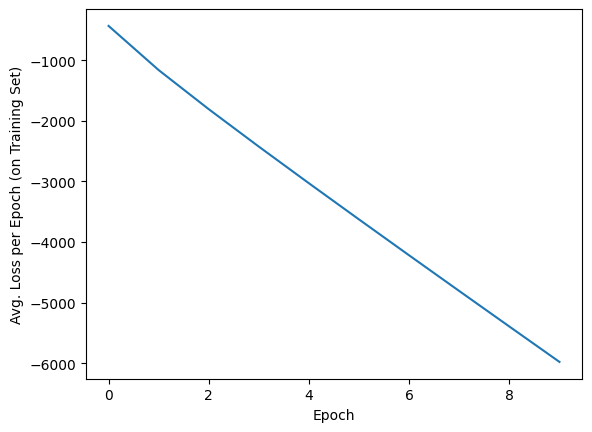

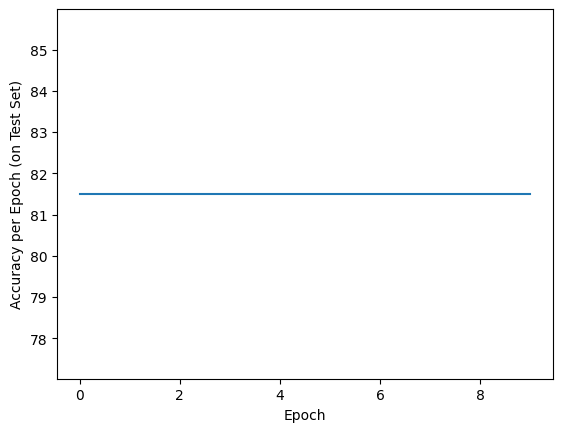

In [ ]:
# Plot results
plt.plot(plot_loss)
plt.xlabel('Epoch')
plt.ylabel('Avg. Loss per Epoch (on Training Set)')
plt.show()

plt.plot(plot_correct)
plt.xlabel('Epoch')
plt.ylabel('Accuracy per Epoch (on Test Set)')
plt.show()